In [ ]:
# Reserved for explanation markdown

In [2]:
from PIL import Image
import scipy
import imageio
import numpy as np
import keras
import os
import time

In [3]:
# Importing all necessary libraries

# TODO: REMOVE EXTRA LIBRARIES
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from tensorflow.keras.utils import to_categorical

In [4]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

I will be loading in a pretrained model called **VGG-16**, a Convolutional Neural Network trained on the ImageNet dataset. I will be using transfer learning to reporpose this CNN to identify planes (model/type).



In [5]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                    input_shape=(150, 150, 3))

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [6]:
# Defining directory for data
base_dir = 'all_airplane'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 40 # Batchsize to train images

# Inputs a directory of data and the amount of data in each directory (in our case pictures)
# Outputs images sectioned by batch size, along with the labels to identify each image
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count, 30))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')
    i = 0
    print(generator)
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels


In [7]:
train_features, train_labels = extract_features(train_dir, 3334)
validation_features, validation_labels = extract_features(validation_dir, 3333)
test_features, test_labels = extract_features(test_dir, 3333)

Found 3334 images belonging to 30 classes.
Found 3333 images belonging to 30 classes.
Found 3333 images belonging to 30 classes.


In [8]:
# One-Hot Encoding
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)
one_hot_val_labels = to_categorical(validation_labels)


In [11]:
# Adding Layers onto the CNN
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(conv_base) # Adding Conv Base
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu', input_dim=5*5*2048)) 
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [12]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [13]:
conv_base.trainable = False

In [14]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


In [15]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the test data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')


Found 3334 images belonging to 30 classes.
Found 3333 images belonging to 30 classes.


In [18]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20, 30)


In [19]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

batch_size = 20
history = model.fit_generator(
      train_generator,
      steps_per_epoch = 100,
      epochs=10,
      validation_data=validation_generator,
      validation_steps = 100)

Epoch 1/10
100/100 [==============================] - 34s 338ms/step - loss: 2.9270 - accuracy: 0.2706 - val_loss: 2.7510 - val_accuracy: 0.0612
Epoch 2/10
100/100 [==============================] - 32s 316ms/step - loss: 2.7164 - accuracy: 0.4175 - val_loss: 2.5440 - val_accuracy: 0.6360
Epoch 3/10
100/100 [==============================] - 32s 324ms/step - loss: 2.6006 - accuracy: 0.6823 - val_loss: 2.4961 - val_accuracy: 0.7245
Epoch 4/10
100/100 [==============================] - 33s 333ms/step - loss: 2.5447 - accuracy: 0.7633 - val_loss: 2.5086 - val_accuracy: 0.7941
Epoch 5/10
100/100 [==============================] - 34s 337ms/step - loss: 2.4677 - accuracy: 0.8337 - val_loss: 2.3868 - val_accuracy: 0.7561
Epoch 6/10
100/100 [==============================] - 31s 313ms/step - loss: 2.3952 - accuracy: 0.8613 - val_loss: 2.4447 - val_accuracy: 0.7468
Epoch 7/10
100/100 [==============================] - 31s 311ms/step - loss: 2.3648 - accuracy: 0.8868 - val_loss: 2.2940 - val_ac

In [26]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=30,
        class_mode='categorical')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('The Test Accuracy of this model is ', round(test_acc, 4))

Found 3333 images belonging to 30 classes.
The Test Accuracy of this model is  0.9362


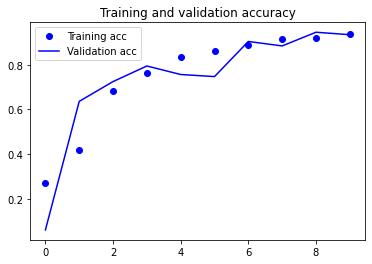

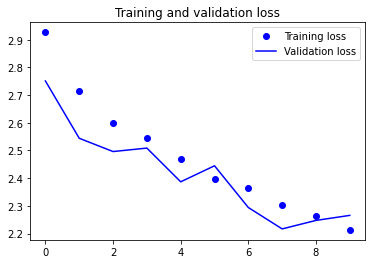

In [27]:
model.save('multi_plane.h5')

import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()